<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: 2.0 Data Cleaning, preprocessing and EDA

> Authors: Pius Yee, Conrad Aw, Eugene Matthew Cheong
---

## Table of Contents ##

### [1.0 Data Collection](./1.0%20Web%20Scraping.ipynb) ###

[1.1 Import Packages](./1.0%20Web%20Scraping.ipynb)

[1.2 Webscraping](./1.0%20Web%20Scraping.ipynb)

[1.3 Selection of subreddits](./1.0%20Web%20Scraping.ipynb)

[1.4 Code for text scraping](./1.0%20Web%20Scraping.ipynb)

### 2.0 Data Cleaning, Preprocessing and EDA

[2.1 Import CSV file](#2.1-Import-CSV-file)

[2.2 Data cleaning](#2.2-Data-cleaning)

[2.3 Preprocessing](#2.3-preprocessing)

[2.4 Exploratory Data Analysis (EDA)](#2.4-Exploratory-Data-Analysis-(EDA))

### [3. Modelling, Evaluation and Tuning](./3.0%20Modelling.ipynb)

[3.1 Import CSV file](./3.0%20Modelling.ipynb)

[3.2 Splitting of train/test data](./3.0%20Modelling.ipynb)

[3.3 Modelling](./3.0%20Modelling.ipynb)

[3.4 Model Selection](./3.0%20Modelling.ipynb)

[3.5 AUC-ROC](./3.0%20Modelling.ipynb)

[3.6 Save it as Pickle](./3.0%20Modelling.ipynb)

[3.7 Recommendations](./3.0%20Modelling.ipynb)

[3.8 Conclusion](./3.0%20Modelling.ipynb)

### [4. Model Testing](./4.0%20Model%20Test.ipynb)

[4.1 Scraping Input Reddit](./4.0%20Model%20Test.ipynb)

[4.2 Cleaning Data](./4.0%20Model%20Test.ipynb)

[4.3 Tokenizing with Regex](./4.0%20Model%20Test.ipynb)

[4.4 Stop Word Removal](./4.0%20Model%20Test.ipynb)

[4.5 Lemmatization](./4.0%20Model%20Test.ipynb)

[4.6 Run the model](./4.0%20Model%20Test.ipynb)

---

##### In this notebook, we will clean the dataset from the previous notebook, and proceed to EDA for better understanding of the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### 2.1 Import CSV file

In [2]:
# import csv

reddit_df = pd.read_csv('../datasets/daddit_mommit_df.csv')

In [3]:
# check the shape

reddit_df.shape

(1701, 7)

### 2.2 Data cleaning

#### Transform and restructure data from DataFrame reddit_df into a new DataFrame final_df. The new DataFrame is structured to have three columns: category, text, and mum as we have identified these as the key data for analysis

In [4]:
# create a new data frame and keep info from title, selftext and comments
raw_df = pd.DataFrame({'category':[],'text':[], "mum":[]})
index_count = 0
# For each row in reddit_df, two rows are added to final_df.
# The first row has the category set to "title", the text set to the title of the Reddit post, and the mum set to the subreddit name.
# The second row has the category set to "selftext", the text set to the self-text of the Reddit post, and the mum set to the subreddit name.
for i in range(reddit_df.shape[0]):
    raw_df.loc[index_count] = ["title",reddit_df.loc[i]['title'],reddit_df.loc[i]['subreddit']]
    index_count += 1
    raw_df.loc[index_count] = ["selftext",reddit_df.loc[i]['selftext'],reddit_df.loc[i]['subreddit']]
    index_count += 1
    # The comments for each Reddit post are split into individual comments using split("', ").
    # Each comment is then added as a new row in final_df with the category set to "comment", the text set to the comment text, and the mum set to the subreddit name.
    for cmt in reddit_df.comments.loc[i].split("', "): # split different comments into separate rows
        raw_df.loc[index_count] = ["comment",cmt,reddit_df.loc[i]['subreddit']]
        index_count += 1


In [5]:
# raw dataframe before processing
raw_df

,category,text,mum
0,title,Dad tips,daddit
1,selftext,I found out a couple weeks ago that some frien...,daddit
2,comment,"[""I hate to post something negative on such a ...",daddit
3,comment,<praw.models.comment_forest.CommentForest obje...,daddit
4,comment,<praw.models.comment_forest.CommentForest obje...,daddit
...,...,...,...
46100,comment,"[""You need to start talking about moving to a ...",Mommit
46101,comment,'We moved from an apartment into our house whe...,Mommit
46102,comment,'Congratulations on your upcoming move to your...,Mommit
46103,comment,'i feel like your daughter might not care. my ...,Mommit


##### Sufficient amount of data collected as shown above.

In [6]:
raw_df.iloc[3]['text']

'<praw.models.comment_forest.CommentForest object at 0x31f8e3d10>, "I think that people should look at the risks and decide what\'s best for them based on their situation. Bedsharing does cause a statistically significant increase in SIDS occurrence, but based on our situation we decided to take that risk because the risk of us doing something fucking idiotic while braindead from sleep deprivation was orders of magnitude more likely. I get why the back is best campaign exists and support it, and I am in no way advocating against it.\\n\\nOur situation: Before cosleeping my wife left an oven burner on overnight and I almost turned left into oncoming traffic. The sleep deprivation was insane. After that we used a sidecar bassinet co-sleeper but daughter always ended up in the bed after her first wake up in order to dream feed. I was hyper aware of her being in the bed and mom instinctively played defense. Mom exclusively breastfed and she \'spooned\' or cradled baby during nights. We had

### Now we have raw dataframe before data processing. To fit the data into the model, the following steps performed to clean the data.

#### (a) Convert the "mum" column to binary column. 1 is for mum, and 0 is for dad.

In [7]:
# update "mum" column to binary
 
raw_df.mum = raw_df.mum.apply(lambda x: 1 if x == "Mommit" else 0)

#### (b) The extracted comments contain some invalid codes (<praw.models.comment_forest.CommentForest object at xxxx>). These will be removed as they are not legitimate comments."

In [8]:
# create a function to remove the <praw xxx> invalid codes
def remove_characters(text):
  #print(row)
  pattern = '<[^>]*>'
  # <Praw> will be replaced with nothing
  replacement = ''

  result_string = re.sub(pattern, replacement, str(text))

  return result_string

In [9]:
# apply the function on raw_df - text

raw_df['text'] = raw_df['text'].apply(remove_characters)

In [10]:
# check if there are any <praw xxxx> invalid code in the updated dataframe

raw_df['text'].str.contains("<praw").value_counts()

text
False    46105
Name: count, dtype: int64

#### (c) To remove comments with [removed] and [deleted]

In [11]:
# further remove comments with "[removed] and [deleted]"
raw_df = raw_df[~raw_df['text'].apply(lambda x: any(word in x for word in ['[removed]','[deleted]']))]

#### (d) To replace space '\n' with ''

In [12]:
raw_df['text'] = raw_df['text'].replace('\n', '')

/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/3407300058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['text'] = raw_df['text'].replace('\n', '')


#### (e) Remove special characters

In [13]:
# Removing special characters from the 'text' column
raw_df['text'] = raw_df['text'].replace(r'[^a-zA-Z0-9\?\! ]', '', regex=True)

/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/1675266753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['text'] = raw_df['text'].replace(r'[^a-zA-Z0-9\?\! ]', '', regex=True)


#### (f) Remove duplicate comments that appear to be auto-replies or system messages

In [14]:
# create a new data frame
check_auto = pd.DataFrame(raw_df.text.value_counts())
check_auto = check_auto.reset_index()

# identify auto bot message with duplicate same message and more than 20 words
check_auto = check_auto[(check_auto.text.str.len() >20) & (check_auto['count'] > 2)]
check_auto

,text,count
1,This post has been flaired Support Moderation...,64
15,Your comment was removed because Amazon Affil...,6
16,Removed per Rule 1 No blogs surveys or promot...,6
23,We have ants! The little tiny ones that come i...,4
39,Make sure this time that you use a more defens...,3
41,Just let her do it man at the end of the day i...,3


In [15]:
# remove the bot message from the dataframe
raw_df = raw_df[~raw_df['text'].isin(list(check_auto.text))]

#### (g) check and remove blank rows

In [16]:
# identify is there any blank row in the data

raw_df[raw_df.text == ""].text.value_counts()

text
    169
Name: count, dtype: int64

In [17]:
# remove the rows with blank text, and save it as final_df

final_df = raw_df[~raw_df['text'].map(lambda x: x == "" or pd.isnull(x))]

#### (h) check missing values

In [18]:
# check for missing values

final_df.isnull().sum()

category    0
text        0
mum         0
dtype: int64

In [19]:
# check the shape

final_df.shape

(45524, 3)

#### Export the cleaned data to csv

In [20]:
final_df.to_csv('../datasets/final_df.csv')

#### The data is cleaned and ready for further processing.
---

### 2.3 Preprocessing

#### a) Tokenization with Regex

#### Tokenization is the process of chopping text into smaller, digestible pieces for computers. We use tokenization with regex breaks text into words for model training.

In [21]:
# instantiate Tokenizer with Regex
tokenizer = RegexpTokenizer(r'[^\d\W]+') # keep words only

In [22]:
# Run Tokenizer for text
final_df['text'] = final_df['text'].astype("str") # set the text to string
final_df['text'] = [tokenizer.tokenize(x.lower()) for x in list(final_df.text)] #tokenize into words by rows

/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/732282762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = final_df['text'].astype("str") # set the text to string


/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/732282762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = [tokenizer.tokenize(x.lower()) for x in list(final_df.text)] #tokenize into words by rows


In [23]:
# print the dataframe after tokenization

final_df.head()

,category,text,mum
0,title,"[dad, tips]",0
1,selftext,"[i, found, out, a, couple, weeks, ago, that, s...",0
3,comment,"[i, think, that, people, should, look, at, the...",0
5,comment,"[no, one, hates, air, conditioning, our, house...",0
6,comment,"[dont, cosleep, aside, from, sids, theres, als...",0


#### b) Stop Word Removal

#### Stop word removal is a common preprocessing step in natural language processing (NLP) where frequently occurring words with low semantic value are filtered out.  This process helps reduce noise, improve computational efficiency, and emphasize the more content-rich words within the text.

In [24]:
# examples of stop words from "english" dict

print(list(set(stopwords.words('english')))[:10])  

['these', 'all', 'some', 'while', 'them', 'd', 'be', 'mightn', 'isn', 'about']


In [25]:
# Remove stopwords with "english" dict

final_df['text'] = final_df['text'].apply(lambda x: [token for token in x if token not in stopwords.words('english')])

/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/3312761706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = final_df['text'].apply(lambda x: [token for token in x if token not in stopwords.words('english')])


In [26]:
# print dataframe after stopwords

final_df.head(3)

,category,text,mum
0,title,"[dad, tips]",0
1,selftext,"[found, couple, weeks, ago, friends, pregnant,...",0
3,comment,"[think, people, look, risks, decide, whats, be...",0


#### c) Lemmatization

#### Lemmatization is a linguistic normalization technique in natural language processing (NLP) that converts inflected forms of a word to its base form or lemma. It uses vocabulary and morphological analysis to determine the correct lemma, taking into consideration the word's part of speech and its context within the text. This process helps in reducing the feature space and improving the accuracy of NLP models by grouping together different variants of the same word.

#### For example, (running, runs, ran) > run

In [27]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [28]:
# to lemmatize words

lst = []
for row in list(final_df['text']):
    lst.append([lemmatizer.lemmatize(i) for i in row])

final_df['text'] = lst

/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5704/1374161525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = lst


In [29]:
# print dataframe after lemmazation

final_df

,category,text,mum
0,title,"[dad, tip]",0
1,selftext,"[found, couple, week, ago, friend, pregnant, f...",0
3,comment,"[think, people, look, risk, decide, whats, bes...",0
5,comment,"[one, hate, air, conditioning, house, made, pr...",0
6,comment,"[dont, cosleep, aside, sids, there, also, chan...",0
...,...,...,...
46100,comment,"[need, start, talking, moving, new, house, rea...",1
46101,comment,"[moved, apartment, house, son, month, old, mov...",1
46102,comment,"[congratulation, upcoming, move, new, house, m...",1
46103,comment,"[feel, like, daughter, might, care, best, frie...",1


In [30]:
# export final dataframe to csv

final_df.to_csv("../datasets/final_df.csv")

---
### 2.4 Exploratory Data Analysis (EDA)

### Exploratory Data Analysis (EDA) is the initial investigation of data using statistical summaries and visualizations. It aims to understand the data's underlying structure, identify patterns and helps in model selection for effective analysis.

#### (a) N-Gram analysis

##### N-gram analysis is a technique used to understand sequences of words (n-grams) within a text. It breaks down text into chunks of n words (e.g., 2-gram for 2 words, 3-gram for 3) and analyzes their frequency or co-occurrence. This helps uncover common phrases, identify patterns in language use.

In [31]:
mum_lst = []
dad_lst = []

for p in list(final_df[final_df.mum == 1].text):
    for pp in p: mum_lst.append(pp)

for p in list(final_df[final_df.mum == 0].text):
    for pp in p: dad_lst.append(pp)

In [32]:
pd.Series(nltk.ngrams(mum_lst, 1)).value_counts()[:10]

(like,)       6808
(im,)         5886
(time,)       5777
(get,)        5565
(kid,)        5428
(dont,)       4855
(baby,)       4623
(would,)      4180
(one,)        3955
(husband,)    3675
Name: count, dtype: int64

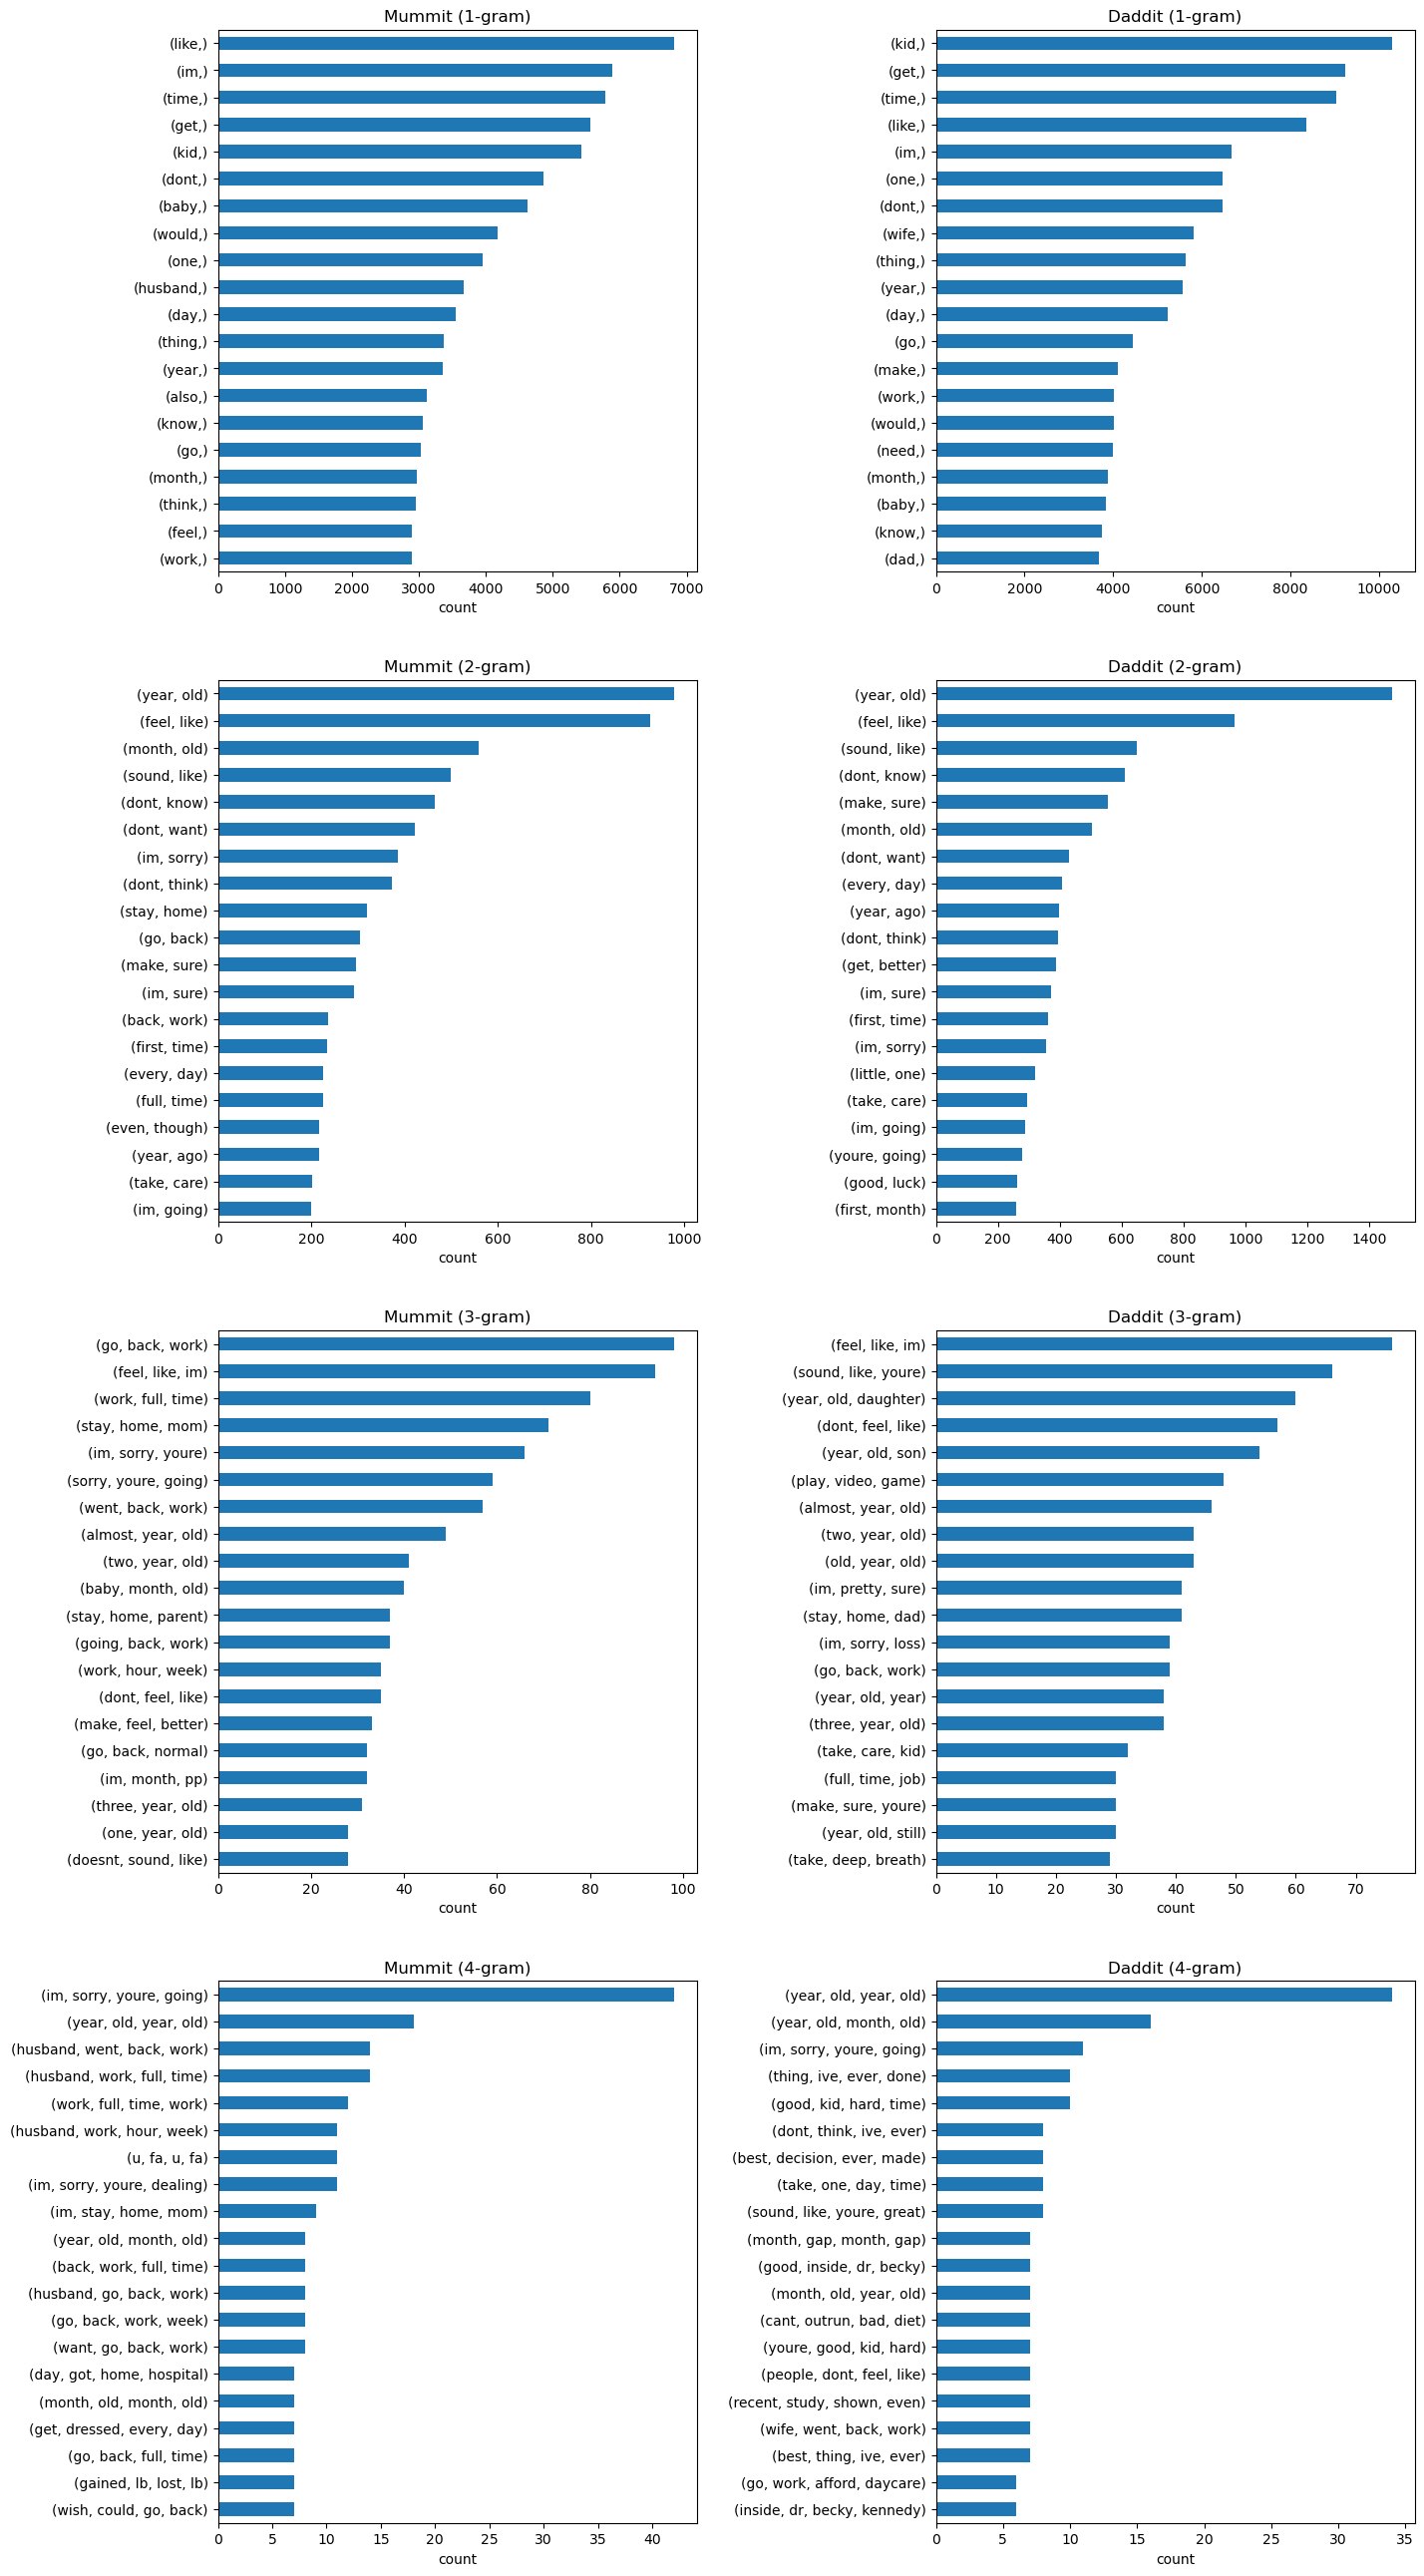

In [33]:
# plotting for N-gram

fig, axes = plt.subplots(4, 2, figsize=(15,50)) 
pd.Series(nltk.ngrams(mum_lst, 1)).value_counts().sort_values()[-20:].plot(kind='barh',title='Mummit (1-gram)',ax=axes[0,0], xlabel='count')
pd.Series(nltk.ngrams(dad_lst, 1)).value_counts().sort_values()[-20:].plot(kind='barh',title='Daddit (1-gram)',ax=axes[0,1], xlabel='count')
pd.Series(nltk.ngrams(mum_lst, 2)).value_counts().sort_values()[-20:].plot(kind='barh',title='Mummit (2-gram)',ax=axes[1,0], xlabel='count')
pd.Series(nltk.ngrams(dad_lst, 2)).value_counts().sort_values()[-20:].plot(kind='barh',title='Daddit (2-gram)',ax=axes[1,1], xlabel='count')
pd.Series(nltk.ngrams(mum_lst, 3)).value_counts().sort_values()[-20:].plot(kind='barh',title='Mummit (3-gram)',ax=axes[2,0], xlabel='count')
pd.Series(nltk.ngrams(dad_lst, 3)).value_counts().sort_values()[-20:].plot(kind='barh',title='Daddit (3-gram)',ax=axes[2,1], xlabel='count')
pd.Series(nltk.ngrams(mum_lst, 4)).value_counts().sort_values()[-20:].plot(kind='barh',title='Mummit (4-gram)',ax=axes[3,0], xlabel='count')
pd.Series(nltk.ngrams(dad_lst, 4)).value_counts().sort_values()[-20:].plot(kind='barh',title='Daddit (4-gram)',ax=axes[3,1], xlabel='count')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.6, wspace=0.5, hspace=0.2)
# Reverse the y-axis
sns.set_palette("Set3")

##### Summary of findings from the above N-gram analysis:
1-gram: Unable to differentiate between mothers and fathers as the top keywords are very similar in both r/Mummit and r/daddit. Kids appear to be more important to both mothers and fathers as compared to their respective partners.

2-gram: Still unable to differentiate between mothers and fathers as the top phrases remain very similar in both r/Mummit and r/daddit. 2-word phrases seem to surround uncertainty. 

3-gram: Differences start to appear between mothers and fathers as the top phrases in r/Mummit are about work, followed by kids. For r/daddit, top phrases are about personal feelings, kids and playing video games.

4-gram: Distinct differences between mothers and fathers as the top phrases in r/Mummit are about husband having to work and going back to work. For r/daddit, top phrases are about kids, empathy and making decisions.



#### (b) length of comments

In [34]:
# create a new column for length of comments in raw_df

raw_df["length"] = raw_df.text.apply(lambda x: len(x))
raw_df

,category,text,mum,length
0,title,Dad tips,0,8
1,selftext,I found out a couple weeks ago that some frien...,0,19787
3,comment,I think that people should look at the risks ...,0,1661
5,comment,No one hates air conditioning Our houses are ...,0,481
6,comment,Dont cosleep Aside from SIDS theres also the c...,0,72
...,...,...,...,...
46100,comment,You need to start talking about moving to a ne...,1,737
46101,comment,We moved from an apartment into our house when...,1,494
46102,comment,Congratulations on your upcoming move to your ...,1,768
46103,comment,i feel like your daughter might not care my be...,1,1132


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

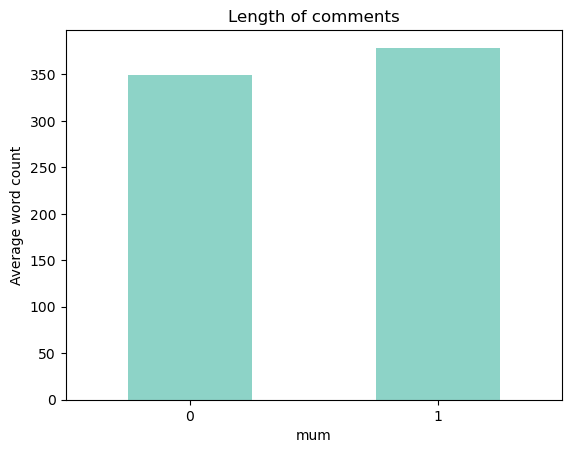

In [35]:
raw_df[raw_df['category'] == "comment"][['category','mum','length']].groupby('mum')['length'].mean().plot(kind='bar', ylabel="Average word count");
plt.title("Length of comments")
plt.xticks(rotation=0)

##### Based on the above analysis, comments of "mum"(1) have higher average word count than "father"(0). However, the difference is not too distinct.

#### (c) Sentiment analysis

In [36]:
# instantiate sentiment analyzer
sent = SentimentIntensityAnalyzer()

In [37]:
# create one more column for sentiment

raw_df['sentiment_score'] = raw_df.text.apply(lambda x: sent.polarity_scores(x)['compound']) # save sentiment score
raw_df['sentiment'] = raw_df.sentiment_score.apply(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral") # save sentiment above 0.05 as positive, below 0.05 as negative, and in between as 'neutral'

In [38]:
# print dataframe after sentiment analyzer
raw_df

,category,text,mum,length,sentiment_score,sentiment
0,title,Dad tips,0,8,0.0000,neutral
1,selftext,I found out a couple weeks ago that some frien...,0,19787,0.9996,positive
3,comment,I think that people should look at the risks ...,0,1661,-0.1869,negative
5,comment,No one hates air conditioning Our houses are ...,0,481,-0.3736,negative
6,comment,Dont cosleep Aside from SIDS theres also the c...,0,72,-0.1280,negative
...,...,...,...,...,...,...
46100,comment,You need to start talking about moving to a ne...,1,737,0.4497,positive
46101,comment,We moved from an apartment into our house when...,1,494,0.3384,positive
46102,comment,Congratulations on your upcoming move to your ...,1,768,0.9824,positive
46103,comment,i feel like your daughter might not care my be...,1,1132,0.9398,positive


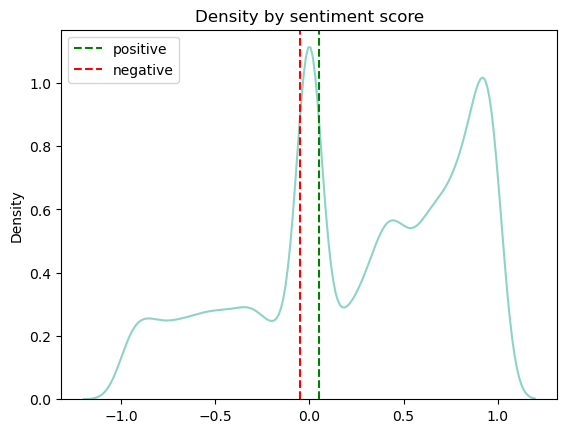

In [39]:
# plot distribution for sentiment score

sns.kdeplot(data=raw_df[['sentiment_score']]);
plt.axvline(x=0.05,color='green',label='positive',linestyle='--')
plt.axvline(x=-0.05,color='red',label="negative",linestyle='--')
plt.title('Density by sentiment score')
plt.legend()

##### Based on the observation of the above curve, comments in both subreddits have more positive sentiments (above 0.05 green line) than negative sentiments (below -0.05 red line).

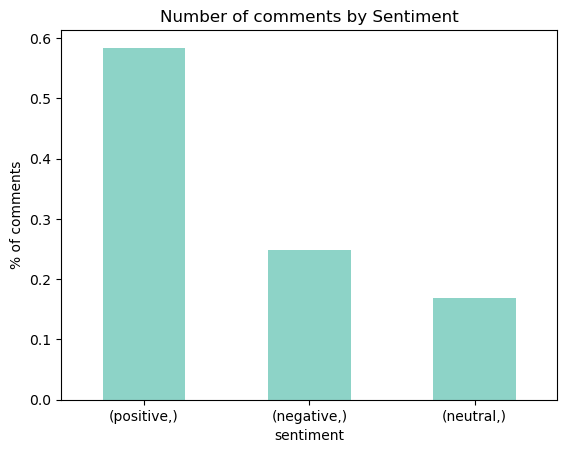

In [40]:
# plot number of comments by sentiment with bar chart

raw_df[['sentiment']].value_counts(normalize=True).plot(kind='bar',title="Number of comments by Sentiment", ylabel="% of comments");
plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.3)
plt.show()

##### Overall, positive comments are the majority in the data, followed by negative and neutral.

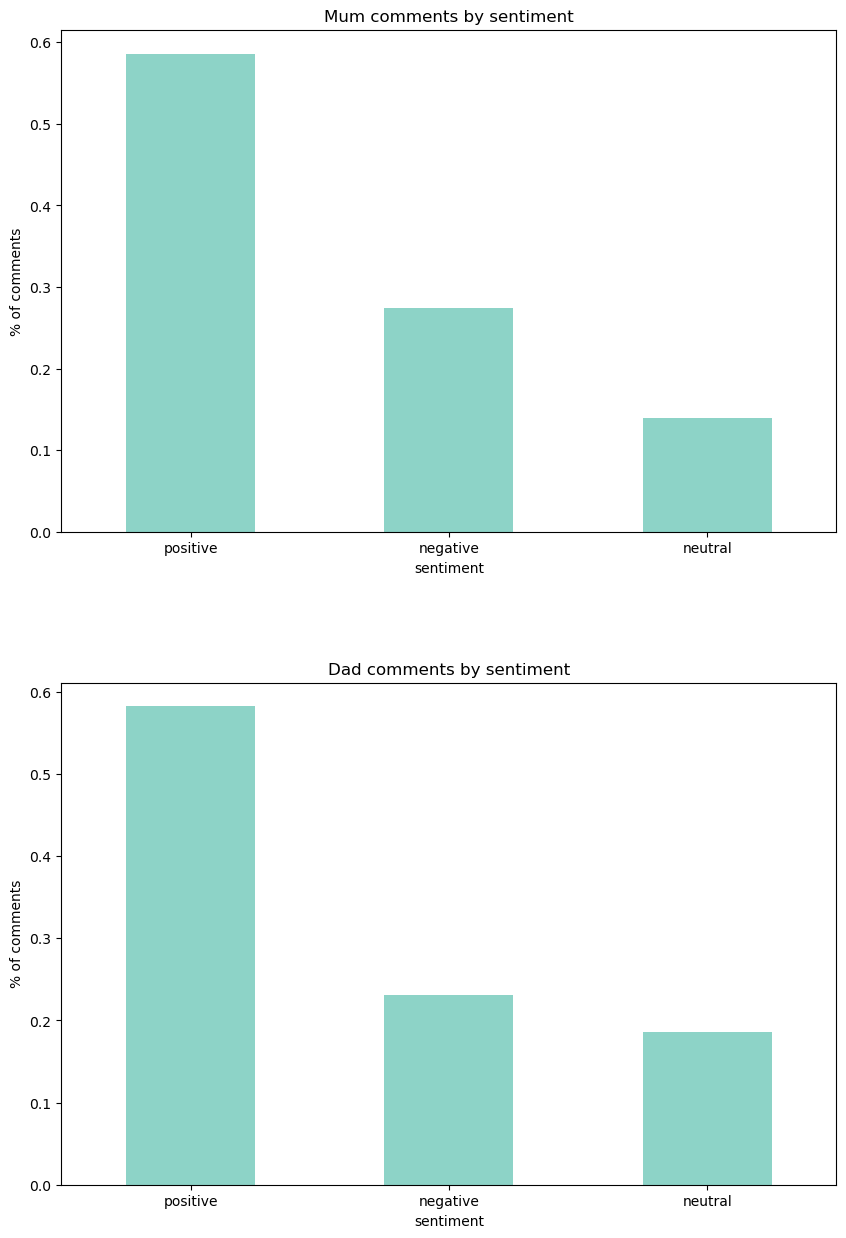

In [41]:
# comments by sentiment

fig, axes = plt.subplots(2, 1, figsize=(10,15)) 
raw_df[raw_df.mum == 1].sentiment.value_counts(normalize=True).plot(kind='bar',title="Mum comments by sentiment",ax=axes[0], ylabel="% of comments"); # plot mum comments
axes[0].set_xticklabels(['positive','negative','neutral'], rotation=0)
raw_df[raw_df.mum == 0].sentiment.value_counts(normalize=True).plot(kind='bar',title="Dad comments by sentiment",ax=axes[1], ylabel="% of comments"); # plot dad comments
axes[1].set_xticklabels(['positive','negative','neutral'], rotation=0)
plt.subplots_adjust(hspace=0.3)


##### Both "mum" and "dad" have highest proportion of positive sentiment.

#### Next Notebook: [3.0 Modelling and Conclusion](./3.0%20Modelling.ipynb)